We need some code to get image embeddings, so let's add that. We are going to use a ResNeXt model and read the final avgpool layer.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 158MB/s]


Let's get the image embeddings and thumbnails so we can build an interactive plot.

In [2]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

THUMBNAIL_SIZE = (64, 64)
TRAIN = '/kaggle/input/chestnut-varieties-dataset/Chestnut Dataset/'


def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def get_picture_from_glob(arg: str, tag: str,) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[tag, basename(input_file), embed(model=model, filename=input_file), png(filename=input_file)],
                        index=['tag', 'name', 'value', 'png'])
        for index, input_file in enumerate(list(iglob(pathname=arg))) if (input_file.endswith('.jpg') or input_file.endswith('.JPG')) and index < 500]
    print('encoded {} rows of {}  in {}'.format(len(result), tag, arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, tag=key) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 304 rows of simav  in 0:00:47.505000
encoded 228 rows of aydın  in 0:00:38.744087
encoded 352 rows of zonguldak  in 0:00:54.045244
encoded 272 rows of alandız  in 0:00:47.015874
done in 0:03:07.405861


We are going to use all the data because we don't have a lot; our classes are a little unbalanced and that will probably have some impact on our model accuracy.

Next let's use TSNE to get x/y coordinates from our image embeddings.

In [3]:
import arrow
from sklearn.manifold import TSNE

time_start = arrow.now()
reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='pca')
train_df[['x', 'y']] = reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
print('done with TSNE in {}'.format(arrow.now() - time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1156 samples in 0.009s...
[t-SNE] Computed neighbors for 1156 samples in 0.242s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1156
[t-SNE] Computed conditional probabilities for sample 1156 / 1156
[t-SNE] Mean sigma: 1.476171
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.865921
[t-SNE] KL divergence after 1000 iterations: 1.140405
done with TSNE in 0:00:06.157391


Now we're ready to plot.

In [4]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'tag', 'x', 'y']])
factor_count = max(train_df['tag'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'tag', palette=palette, factors=train_df['tag'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: chestnuts', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@tag</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=7, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? If we look at individual images they all look really similar, but TSNE does a pretty good job of clustering vectors from the same class near each other. So we can be optimistic that our model will be accurate. Let's build a model and find out.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['tag'], test_size=0.4, random_state=2024, stratify=train_df['tag'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 301 iterations
accuracy: 0.9741
f1: 0.9739
              precision    recall  f1-score   support

     alandız       0.96      1.00      0.98       109
       aydın       0.99      0.92      0.95        91
       simav       0.98      0.99      0.99       122
   zonguldak       0.97      0.97      0.97       141

    accuracy                           0.97       463
   macro avg       0.97      0.97      0.97       463
weighted avg       0.97      0.97      0.97       463



An f1 of 0.936 isn't bad for so little work. Let's make a secondary plot to see where our low model probabibilities lie. We expect them to be along the interfaces between local clusters, with neighbors in different classes.

<Axes: xlabel='x', ylabel='y'>

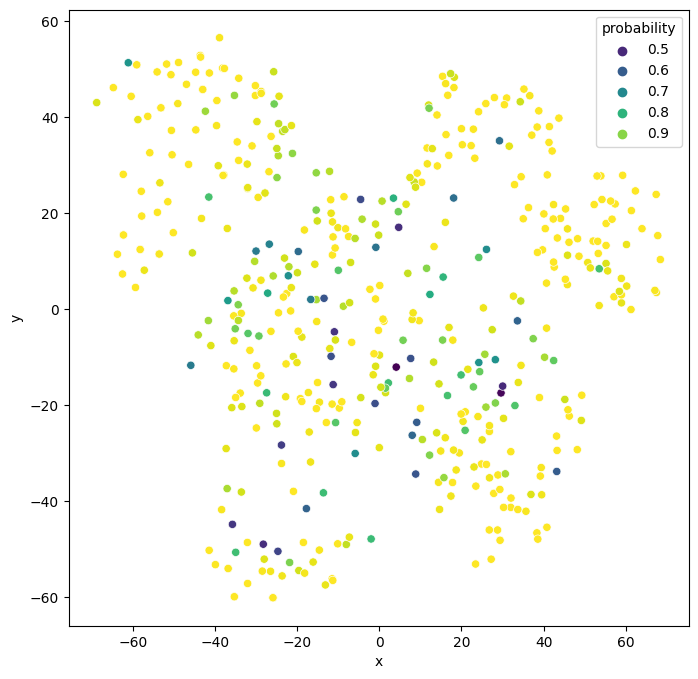

In [6]:
import matplotlib.pyplot as plt
from seaborn import scatterplot

fig, ax = plt.subplots(figsize=(8, 8))
plot_df = train_df.loc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)
scatterplot(ax=ax, data=plot_df, x='x', y='y', hue='probability', palette='viridis')

And that is for the most part what we see. 